**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2022</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: DEC 23, 2022 23:59 (GMT+3)</center></h4>

In this third homework assignment, you are asked to develop a system that can be used to supply additional information to weather forecasts. For this task, you are provided a dataset that consists of weather images that belong to four different weather conditions: [cloudy, rain, shiny, sunrise]. Your model will classify images considering these class labels. 

For this assignment, **using PyTorch is mandatory.**

**Tip:** You may experience latencies in file I/O if you are using Google Colab. In this regard, we recommend you upload your data to Google Drive as a zip file and unzip the folder contents in your drive. If you would like to upload the data files separately, it may take significant time.

You will submit a single ipynb file as the homework submission. If you want to provide further explanation about your work, you can add Markdown cells to do so. [Here](https://www.markdownguide.org/), you can find a guide for Markdown syntax. Upload your homework with the following filename convention: \<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb


**Dataset**<br>
You can find the dataset [here](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset). 


# **Q1** [12 points]
This part consists of 4 questions which you are expected to answer. Please fill in the following cell in Markdown format. Each question is worth 2 points.

**a)** Do we need to output the actual probability values when performing classification with the softmax layer? If not, how do these numbers represent the likelihood of classes? Also, does the output values should be in a specific range for us to make a classification? <br>

**Answer:** We do not need the actual probability values while performing classification with softmax, they represent how confident we should be during classification. The class having the highest probability is chosen as the output of the classification. The outputs should be in the range [0,1].

**b)** From the perspective of model complexity, how you can identify when a model underfits or overfits? Which plots are informative for detecting this behavior? <br>

**Answer:** If training accuracy converges to a near 1 but validation accuracy is significantly low, then the model overfits. Also, if the loss of the training data converges to a really low value while loss of the validation is significantly higher, then the model overfits. 

If both the training and validation accuracies are low or both of their losses are high, then the model underfits. Hence we can interpret these situations using loss and accuracy plots of training and validation data.

**c)** In neural networks, how does the ReLU function help us to generalize to complex feature spaces? Why we are not using linear layers only? <br>

**Answer:** Since ReLU deactivates neurons if their linear transformation is less than zero, in other words, it does not activate all the neurons at the same time, it is more computationally efficient compared to other functions. 

**d)** Assume that you are going to pass the feature matrix with dimensions 64x64x5 (Height x Width x Channel size) through a convolutional layer. If our convolutional layer has a kernel size of 3x3 and the number of filters is 6, how many learnable parameters are present? <br>

**Answer:** For the learnable parameters, we use the formula 
num_learnable_parameters = (kernel_width * kernel_height * input_ch_size+1)*num_filters

Hence, (3 * 3 * 5 + 1) * 6 = 276

# **Q2** [88 points]

## Necessary Imports
In the cell below, we import some utilities that you can make use of in this assignment. Note that you need to use PyTorch in this assignment. To report certain metrics (like precision, recall, accuracy) you may use utilities from *scikit-learn* library. You can edit these imports considering your implementation as long as you use PyTorch.

## Setup

In [ ]:
import os 
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score

You can test whether hardware acceleration with GPU is enabled in the cell below. In addition, if you have GPU access, you can check the amount of available GPU memory.

In [ ]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: Tesla T4
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     14.8 GB


**DO NOT CHANGE**<br>
To evaluate your implementation fairly, we set seed values for random sampling methods in PyTorch, Numpy, and Python random library. These seeds are set to evaluate your models successfully, so do not change these values.

In [ ]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

## Load Data [6 points]
In this assignment, you will use a custom dataset, which you need a wrapper class to access its data. For this purpose, implement a custom dataset class to organize data with the specifications you need. This class will load batches of data using a PyTorch DataLoader later. The class signature of CustomDataset class is provided to you in the cell below, where you can implement your custom dataset.

**IMPORTANT:** As you may have difficulties while fitting all images to your RAM, you need to read the images while getting that item (each item is an image here). We encourage you to read the data files in the "__getitem__" function to avoid encountering any issues related to fitting the data to memory. This way, you do not need to hold the dataset in a single variable, which would be memory intensive.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, **kwargs):
      self.data = data
      self.labels = labels

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.labels)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        image = self.data[index,:,:,:]
        ground_truth = self.labels[index]
        return image, ground_truth

You can implement an additional function to read and construct custom dataset objects for training, validation, and test sets. While constructing the dataset, consider the following issues:
- Dataset contains images that end with prefixes *.jpg* and *.jpeg*.
- If you use PIL to read images, you should convert them to "RGB" format to operate on three color channels.
- Resize the dataset images to 224x224. You are going to design models that take images with tensor shape 224x224x3.
- If you wish, you can change the ordering of the color channels with np.moveaxis function

Lastly, the train-validation-test split for the dataset provided to you is 70-10-20 in terms of percentages. While constructing the dataset, remember that shuffling is a necessary step (to get randomly distributed classes across batches).

You can design your dataset getter method compatible with the line provided below, where train_dataset, val_dataset, and test_dataset are all instances of CustomDataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/CS464/HW3/weather_images.zip

Archive:  /content/drive/MyDrive/CS464/HW3/weather_images.zip
replace Multi-class Weather Dataset/Cloudy/cloudy1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
pathList = [r'/content/Multi-class Weather Dataset/Cloudy',
            r'/content/Multi-class Weather Dataset/Rain',
            r'/content/Multi-class Weather Dataset/Shine',
            r'/content/Multi-class Weather Dataset/Sunrise']

In [ ]:
count = 0
imageList = []
labels = []
print(type(imageList))
for i in range(len(pathList)):
  for img in os.listdir(pathList[i]):
    imgPath = os.path.join(pathList[i],img)
    # Convert the image to PyTorch tensor
    transform_with_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])
    image = Image.open(imgPath).convert(mode = "RGB")
    image = transform_with_resize(image)
    imageList.append(np.array(image))
    #cloudy:0, rain:1, shine:2, sunrise:3
    labels.append(i)
imageList = np.array(imageList).astype('float32')
labels = torch.Tensor(labels).int()

<class 'list'>


In [ ]:
train_size = 788 #70%
valid_size = 112 #10%
test_size = 225 #20%

train_data = torch.zeros(train_size,3,224,224)
train_label = torch.zeros(train_size)
valid_data = torch.zeros(valid_size,3,224,224)
valid_label = torch.zeros(valid_size)
test_data = torch.zeros(test_size,3,224,224)
test_label = torch.zeros(test_size)

#Normalizing the data 
mean = np.mean(imageList, axis = 0)
std = np.std(imageList, axis = 0)
dataset = (imageList-mean)/std
dataset = torch.from_numpy(dataset)

In [ ]:
#Creating permutations of data from 0 to len(dataset)-1 
#Later to be used for shuffling
index = torch.randperm(len(dataset))

In [ ]:
#Shuffling and splitting the dataset
idx_data = 0
for i in index:
    if idx_data < train_size:
      train_data[idx_data,:,:,:], train_label[idx_data] = dataset[i,:,:,:], labels[i]

    elif train_size <= idx_data < train_size + valid_size:
      valid_data[idx_data-train_size,:,:,:], valid_label[idx_data-train_size] = dataset[i,:,:,:], labels[i]
      
    else:
      test_data[idx_data-(train_size + valid_size),:,:,:], test_label[idx_data-(train_size + valid_size)] = dataset[i,:,:,:], labels[i]
    idx_data +=1

In [ ]:
#Merging data with labels by calling the CustomDataset method
merged_train_data = CustomDataset(train_data, train_label)
merged_valid_data = CustomDataset(valid_data, valid_label)
merged_test_data = CustomDataset(test_data, test_label)

In [ ]:
#Loading data to DataLoader as (image,label) type and shuffle again
train_dataset = DataLoader(dataset = merged_train_data, batch_size = (64), shuffle = True)
val_dataset = DataLoader(dataset = merged_valid_data, batch_size = (64), shuffle = True)
test_dataset = DataLoader(dataset = merged_test_data, batch_size = (64), shuffle = True)


## Models [16 points]
In this assignment, you will implement one CNN (Convolutional Neural Network) model and one FCN (Fully-Connected Network) model, where the class signatures are provided below.

### Convolutional Neural Network (CNN) Model [8 points]
As the first model, you will implement a convolutional model. Your model will include 3 CONV + POOL blocks, which denotes one Convolutional layer followed by a Max Pooling Layer. The channel sizes for convolutional blocks are [16, 32, 64], respectively. For all convolutional layers, take kernel size as 3, stride as one, and apply padding such that convolutions do not change the shape on width and height dimensions. 
<br><br>
Following the convolutional part, you will perform image classification for the dataset provided to you. You can use ReLU activation as the non-linearity in your model (except the classification layer).

In [ ]:
class ConvNet(nn.Module):
    '''Define your convolutional neural network'''
    def __init__(self, channel_sizes = [16,32,64], kernel_size = 3, num_outputs = 4, **kwargs):
      super(ConvNet,self).__init__()
      self.channel_sizes = channel_sizes
      self.kernel_size = kernel_size
      self.num_outputs = num_outputs
      self.conv_network = nn.Sequential(
          #The first layer
          nn.Conv2d(in_channels=3, out_channels = self.channel_sizes[0], kernel_size = self.kernel_size, padding = 1),
          nn.BatchNorm2d(self.channel_sizes[0]),
          nn.ReLU(),
          nn.MaxPool2d(2,2),

          #The second layer
          nn.Conv2d(in_channels=self.channel_sizes[0], out_channels = self.channel_sizes[1], kernel_size = self.kernel_size, padding = 1),
          nn.BatchNorm2d(self.channel_sizes[1]),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
      
          #The third layer
          nn.Conv2d(in_channels=self.channel_sizes[1], out_channels = self.channel_sizes[2], kernel_size = self.kernel_size, padding = 1),
          nn.BatchNorm2d(self.channel_sizes[2]),
          nn.ReLU(),
          nn.MaxPool2d(2,2))
      
      #Calculating the output size regarding the kernel sizes of pooling layers 2*2*2 = 8
      self.conv_output_size = 224//8
      self.linear =nn.Sequential( 
          nn.Linear(in_features=self.conv_output_size*self.conv_output_size*self.channel_sizes[2], out_features=64),
          nn.ReLU(),
          nn.Linear(in_features=64, out_features=32),
          nn.ReLU(),
          nn.Linear(in_features=32, out_features=16),
          nn.ReLU(),
          nn.Linear(in_features=16, out_features=self.num_outputs))

    def forward(self, x):
      x = self.conv_network(x)
      #Flattening the image data
      x = x.view(-1,self.conv_output_size*self.conv_output_size*self.channel_sizes[2])
      x = self.linear(x)
      return x

### Fully Connected Network (FCN) Model [8 points]
The second model you will try is a Fully Connected Network composed of Linear layers and non-linear activation functions connected to each other. For this part, the number of features for your linear layers is [1024, 512, 256]. Again, you can use ReLU as your non-linear activation function in your model (except the classification layer).

In [ ]:
class FCNet(nn.Module):
    '''Define your full connected network'''
    def __init__(self, feature_sizes = [1024, 512, 256], num_outputs = 4, **kwargs):
      super(FCNet,self).__init__()
      self.feature_sizes = feature_sizes
      self.num_outputs = num_outputs
      self.network = nn.Sequential(
          #Input layer
          nn.Linear(in_features=224*224*3, out_features=self.feature_sizes[0]),
          nn.ReLU(),

          #Hidden Layer 1
          nn.Linear(in_features=self.feature_sizes[0], out_features=self.feature_sizes[1]),
          nn.ReLU(),

          #Hidden Layer 2
          nn.Linear(in_features=self.feature_sizes[1], out_features=self.feature_sizes[2]),
          nn.ReLU(),

          #Output Layer
          nn.Linear(in_features=self.feature_sizes[2], out_features=self.num_outputs))
  
    def forward(self, x):
      x = x.view(-1,224*224*3)
      x = self.network(x)
      return x

## Training and Evaluation of FCN [22 points]

Now that you implemented the model definition of CNN and FCN, you will train these models with the hyperparameters you chose. The hyperparameters that you may change are listed in the cell below. Using the FCN model defined, train a classifier that predicts weather condition classes specified by the dataset. For the optimizer, use [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer provided by PyTorch. You should try out different hyper-parameters like learning rates, epochs, momentum, and weight decay. For [momentum](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/) and [weight decay](https://paperswithcode.com/method/weight-decay), you can read about these concepts if you are interested.

While training your model, save your best model over different epochs. You must select an appropriate metric to define the best model at a time step. You can implement the training procedure in the cell below. If you want to explain the reasoning behind your metric selection, you can add a markdown cell and provide your comments.

**NOTE**

Instead of writing the same functions for all three of the models, I preferred to write one training and one test functions and try them with the three given methods. The functions are given below. Their outputs give the accuracy and loss scores.

In [ ]:
def train_model(model, cross_entropy, optimizer, num_epochs):
  train_epoch_loss = []
  val_epoch_loss = []
  train_epoch_acc = []
  val_epoch_acc = []
  for i in range(num_epochs):
    model_loss = 0.0
    correct_pred = 0
    print("Epoch: ", i + 1, "/", max_epoch)
    for data, label in tqdm(train_dataset):

        #Setting the gradients to zero
        optimizer.zero_grad()

        #Forward training
        model_output = model(data)
        _, pred = torch.max(model_output,1)
        label = label.to(torch.long)
        batch_loss = cross_entropy(model_output, label)

        #Performing backpropagation
        batch_loss.backward()

        #Updating parameter values
        optimizer.step()
        #Updating the loss 
        model_loss += batch_loss.item()
        
        size = len(train_dataset)
        #Counting the accurate predictions
        accurate_pred = (pred==label).sum().item()
        correct_pred += accurate_pred

    #Print the loss value per epoch
    epoch_loss = model_loss/size
    train_epoch_loss.append(epoch_loss)
    print("The training loss for the", i + 1, "th epoch is", epoch_loss)

    #Print the accuracy value per epoch  
    epoch_acc = correct_pred/train_size
    train_epoch_acc.append(epoch_acc)
    print("The training accuracy for the", i + 1, "th epoch is", epoch_acc)
    
    #Validation data
    val_model_loss = 0
    accurate_count = 0
    #While finding the accuracy and loss values for validation data, we do not need to calculate gradients
    with torch.no_grad():
      for val_data, val_label in val_dataset:
        val_output = model(val_data)
        _, val_pred = torch.max(val_output, 1)
        val_label = val_label.to(torch.long)
        val_loss = cross_entropy(val_output, val_label)
        val_model_loss += val_loss.item()
        accurate_count += (val_pred==val_label).sum().item()
        val_size = len(val_dataset)
      accurate_avg = accurate_count/valid_size
      val_avg_loss = val_model_loss/val_size
      val_epoch_loss.append(val_avg_loss)
      val_epoch_acc.append(accurate_avg)

      print("The validation loss for the", i + 1, "th epoch is", val_avg_loss)
      print("The validation accuracy for the", i + 1, "th epoch is", accurate_avg)

  return train_epoch_acc, train_epoch_loss, val_epoch_acc, val_epoch_loss

In [ ]:
def test_model(model, cross_entropy, optimizer, num_epochs):
  test_pred_label= torch.tensor([])
  test_batch_label = torch.tensor([])
  test_model_loss = 0
  accurate_count = 0
  #While finding the accuracy and loss values for test data, we do not need to calculate gradients
  with torch.no_grad():
    for test_data, test_label in test_dataset:
      test_output = model(test_data)
      _, test_pred = torch.max(test_output, 1)
      test_pred_label = torch.cat((test_pred_label,test_pred),dim=0)
      test_batch_label = torch.cat((test_batch_label,test_label),dim = 0)
      test_label = test_label.to(torch.long)
      test_loss = cross_entropy(test_output, test_label)
      test_model_loss += test_loss.item()
      accurate_count += (test_pred==test_label).sum().item()
    test_avg_loss = test_model_loss/len(test_dataset)
    accurate_avg = accurate_count/test_size

    print("The test accuracy is", accurate_avg)
    
  return accurate_avg, test_pred_label, test_batch_label


In [ ]:
def plot_graph(num_epoch, train_acc,val_acc,train_loss,val_loss):

  # Plotting the graph for accuracy
  plt.plot(np.array(range(num_epoch)), train_acc, label = 'Training Data')
  plt.plot(np.array(range(num_epoch)), val_acc, label ='Validation Data')  

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.title('Number of Epochs vs Accuracy')

  plt.legend() 
  plt.show()

  # Plotting the graph for loss
  plt.plot(np.array(range(num_epoch)), train_loss, label = 'Training Data')
  plt.plot(np.array(range(num_epoch)), val_loss, label ='Validation Data')  

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
    
  plt.title('Number of Epochs vs Loss')

  plt.legend() 
  plt.show()
  return 

### Training [12 points]

In [ ]:
#TODO:
#The optimal hyperparameters are the given ones among what I tried before, except for the number of epochs.
max_epoch = 50
train_batch = 64
test_batch = 64
learning_rate = 5e-2
momentum = 0.5
weight_decay = 5e-04

# TODO: training loop + eval
model_fcn = FCNet()
#Cross-Entropy Loss is used for classification problems and it is the criterion to detect the optimal hyperparameters
cross_entropy = nn.CrossEntropyLoss()
#Implement SGD and get the learnable parameters of the model
optimizer = torch.optim.SGD(model_fcn.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

train_epoch_acc_fcn, train_epoch_loss_fcn, val_epoch_acc_fcn, val_epoch_loss_fcn = train_model(model_fcn, cross_entropy, optimizer, max_epoch)

Epoch:  1 / 50


100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


The training loss for the 1 th epoch is 0.7806829970616561
The training accuracy for the 1 th epoch is 0.6776649746192893
The validation loss for the 1 th epoch is 1.7485661506652832
The validation accuracy for the 1 th epoch is 0.6607142857142857
Epoch:  2 / 50


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


The training loss for the 2 th epoch is 0.7619659029520475
The training accuracy for the 2 th epoch is 0.7550761421319797
The validation loss for the 2 th epoch is 0.6532453298568726
The validation accuracy for the 2 th epoch is 0.7053571428571429
Epoch:  3 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 3 th epoch is 0.45718064445715684
The training accuracy for the 3 th epoch is 0.8236040609137056
The validation loss for the 3 th epoch is 0.6927591860294342
The validation accuracy for the 3 th epoch is 0.75
Epoch:  4 / 50


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


The training loss for the 4 th epoch is 0.3955581681086467
The training accuracy for the 4 th epoch is 0.8718274111675127
The validation loss for the 4 th epoch is 0.923905074596405
The validation accuracy for the 4 th epoch is 0.7053571428571429
Epoch:  5 / 50


100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


The training loss for the 5 th epoch is 0.3621181146456645
The training accuracy for the 5 th epoch is 0.8553299492385786
The validation loss for the 5 th epoch is 0.6333097219467163
The validation accuracy for the 5 th epoch is 0.8035714285714286
Epoch:  6 / 50


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


The training loss for the 6 th epoch is 0.27290223653499895
The training accuracy for the 6 th epoch is 0.8857868020304569
The validation loss for the 6 th epoch is 0.42187584936618805
The validation accuracy for the 6 th epoch is 0.8303571428571429
Epoch:  7 / 50


100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


The training loss for the 7 th epoch is 0.17152180494024202
The training accuracy for the 7 th epoch is 0.9302030456852792
The validation loss for the 7 th epoch is 0.3281799778342247
The validation accuracy for the 7 th epoch is 0.8392857142857143
Epoch:  8 / 50


100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


The training loss for the 8 th epoch is 0.10463022497984079
The training accuracy for the 8 th epoch is 0.9606598984771574
The validation loss for the 8 th epoch is 0.403305321931839
The validation accuracy for the 8 th epoch is 0.8839285714285714
Epoch:  9 / 50


100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


The training loss for the 9 th epoch is 0.07495301474745457
The training accuracy for the 9 th epoch is 0.9771573604060914
The validation loss for the 9 th epoch is 0.6308749318122864
The validation accuracy for the 9 th epoch is 0.8125
Epoch:  10 / 50


100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


The training loss for the 10 th epoch is 0.15144235812700713
The training accuracy for the 10 th epoch is 0.950507614213198
The validation loss for the 10 th epoch is 0.7631403654813766
The validation accuracy for the 10 th epoch is 0.8125
Epoch:  11 / 50


100%|██████████| 13/13 [00:23<00:00,  1.83s/it]


The training loss for the 11 th epoch is 0.15558431612757537
The training accuracy for the 11 th epoch is 0.9467005076142132
The validation loss for the 11 th epoch is 0.4479931443929672
The validation accuracy for the 11 th epoch is 0.8303571428571429
Epoch:  12 / 50


100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


The training loss for the 12 th epoch is 0.06456912323259391
The training accuracy for the 12 th epoch is 0.9784263959390863
The validation loss for the 12 th epoch is 0.5059163719415665
The validation accuracy for the 12 th epoch is 0.8482142857142857
Epoch:  13 / 50


100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


The training loss for the 13 th epoch is 0.1275335762363214
The training accuracy for the 13 th epoch is 0.9555837563451777
The validation loss for the 13 th epoch is 0.5020356476306915
The validation accuracy for the 13 th epoch is 0.8035714285714286
Epoch:  14 / 50


100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


The training loss for the 14 th epoch is 0.04793994666005556
The training accuracy for the 14 th epoch is 0.9885786802030457
The validation loss for the 14 th epoch is 0.8204960227012634
The validation accuracy for the 14 th epoch is 0.7767857142857143
Epoch:  15 / 50


100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


The training loss for the 15 th epoch is 0.06915611243591858
The training accuracy for the 15 th epoch is 0.9784263959390863
The validation loss for the 15 th epoch is 0.4220793694257736
The validation accuracy for the 15 th epoch is 0.8839285714285714
Epoch:  16 / 50


100%|██████████| 13/13 [00:23<00:00,  1.81s/it]


The training loss for the 16 th epoch is 0.033624705858528614
The training accuracy for the 16 th epoch is 0.9898477157360406
The validation loss for the 16 th epoch is 0.48578712344169617
The validation accuracy for the 16 th epoch is 0.875
Epoch:  17 / 50


100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


The training loss for the 17 th epoch is 0.09665145286215612
The training accuracy for the 17 th epoch is 0.9885786802030457
The validation loss for the 17 th epoch is 0.724189430475235
The validation accuracy for the 17 th epoch is 0.8214285714285714
Epoch:  18 / 50


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


The training loss for the 18 th epoch is 0.2961426234016052
The training accuracy for the 18 th epoch is 0.9124365482233503
The validation loss for the 18 th epoch is 0.3871053010225296
The validation accuracy for the 18 th epoch is 0.8482142857142857
Epoch:  19 / 50


100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


The training loss for the 19 th epoch is 0.10115051785340676
The training accuracy for the 19 th epoch is 0.9682741116751269
The validation loss for the 19 th epoch is 0.3913237452507019
The validation accuracy for the 19 th epoch is 0.8392857142857143
Epoch:  20 / 50


100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


The training loss for the 20 th epoch is 0.04086533590004994
The training accuracy for the 20 th epoch is 0.9860406091370558
The validation loss for the 20 th epoch is 0.44156526029109955
The validation accuracy for the 20 th epoch is 0.8482142857142857
Epoch:  21 / 50


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


The training loss for the 21 th epoch is 0.03622592774291451
The training accuracy for the 21 th epoch is 0.9873096446700508
The validation loss for the 21 th epoch is 0.4667656868696213
The validation accuracy for the 21 th epoch is 0.8303571428571429
Epoch:  22 / 50


100%|██████████| 13/13 [00:23<00:00,  1.83s/it]


The training loss for the 22 th epoch is 0.019623711776848022
The training accuracy for the 22 th epoch is 0.9936548223350253
The validation loss for the 22 th epoch is 0.42655719816684723
The validation accuracy for the 22 th epoch is 0.875
Epoch:  23 / 50


100%|██████████| 13/13 [00:16<00:00,  1.31s/it]


The training loss for the 23 th epoch is 0.014368800562806427
The training accuracy for the 23 th epoch is 0.9949238578680203
The validation loss for the 23 th epoch is 0.48334164917469025
The validation accuracy for the 23 th epoch is 0.8660714285714286
Epoch:  24 / 50


100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


The training loss for the 24 th epoch is 0.012983534001530362
The training accuracy for the 24 th epoch is 0.9961928934010152
The validation loss for the 24 th epoch is 0.47818411886692047
The validation accuracy for the 24 th epoch is 0.8660714285714286
Epoch:  25 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 25 th epoch is 0.005660642359334116
The training accuracy for the 25 th epoch is 0.9974619289340102
The validation loss for the 25 th epoch is 0.46071507036685944
The validation accuracy for the 25 th epoch is 0.8660714285714286
Epoch:  26 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 26 th epoch is 0.002205327184548458
The training accuracy for the 26 th epoch is 1.0
The validation loss for the 26 th epoch is 0.4651198610663414
The validation accuracy for the 26 th epoch is 0.8660714285714286
Epoch:  27 / 50


100%|██████████| 13/13 [00:16<00:00,  1.30s/it]


The training loss for the 27 th epoch is 0.001778167139631338
The training accuracy for the 27 th epoch is 1.0
The validation loss for the 27 th epoch is 0.4911176711320877
The validation accuracy for the 27 th epoch is 0.8660714285714286
Epoch:  28 / 50


100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


The training loss for the 28 th epoch is 0.001449612623008971
The training accuracy for the 28 th epoch is 1.0
The validation loss for the 28 th epoch is 0.4875718504190445
The validation accuracy for the 28 th epoch is 0.8660714285714286
Epoch:  29 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 29 th epoch is 0.0012083741334768443
The training accuracy for the 29 th epoch is 1.0
The validation loss for the 29 th epoch is 0.5396410524845123
The validation accuracy for the 29 th epoch is 0.8660714285714286
Epoch:  30 / 50


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


The training loss for the 30 th epoch is 0.001003347442467482
The training accuracy for the 30 th epoch is 1.0
The validation loss for the 30 th epoch is 0.5301178097724915
The validation accuracy for the 30 th epoch is 0.8660714285714286
Epoch:  31 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 31 th epoch is 0.000884028360955059
The training accuracy for the 31 th epoch is 1.0
The validation loss for the 31 th epoch is 0.5055493414402008
The validation accuracy for the 31 th epoch is 0.8660714285714286
Epoch:  32 / 50


100%|██████████| 13/13 [00:16<00:00,  1.30s/it]


The training loss for the 32 th epoch is 0.0007962330419104546
The training accuracy for the 32 th epoch is 1.0
The validation loss for the 32 th epoch is 0.5436002016067505
The validation accuracy for the 32 th epoch is 0.8660714285714286
Epoch:  33 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 33 th epoch is 0.0007200408100078886
The training accuracy for the 33 th epoch is 1.0
The validation loss for the 33 th epoch is 0.5471133589744568
The validation accuracy for the 33 th epoch is 0.8660714285714286
Epoch:  34 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 34 th epoch is 0.0006582526302036757
The training accuracy for the 34 th epoch is 1.0
The validation loss for the 34 th epoch is 0.5552961230278015
The validation accuracy for the 34 th epoch is 0.8660714285714286
Epoch:  35 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 35 th epoch is 0.0005860924183462674
The training accuracy for the 35 th epoch is 1.0
The validation loss for the 35 th epoch is 0.5657947659492493
The validation accuracy for the 35 th epoch is 0.8660714285714286
Epoch:  36 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 36 th epoch is 0.0005453612270335165
The training accuracy for the 36 th epoch is 1.0
The validation loss for the 36 th epoch is 0.5879543423652649
The validation accuracy for the 36 th epoch is 0.8660714285714286
Epoch:  37 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 37 th epoch is 0.0004944747208635538
The training accuracy for the 37 th epoch is 1.0
The validation loss for the 37 th epoch is 0.5167698487639427
The validation accuracy for the 37 th epoch is 0.8660714285714286
Epoch:  38 / 50


100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


The training loss for the 38 th epoch is 0.0004931300399430955
The training accuracy for the 38 th epoch is 1.0
The validation loss for the 38 th epoch is 0.5588600635528564
The validation accuracy for the 38 th epoch is 0.8571428571428571
Epoch:  39 / 50


100%|██████████| 13/13 [00:16<00:00,  1.31s/it]


The training loss for the 39 th epoch is 0.00043679424267723405
The training accuracy for the 39 th epoch is 1.0
The validation loss for the 39 th epoch is 0.5594243109226227
The validation accuracy for the 39 th epoch is 0.8660714285714286
Epoch:  40 / 50


100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


The training loss for the 40 th epoch is 0.00045286762626626744
The training accuracy for the 40 th epoch is 1.0
The validation loss for the 40 th epoch is 0.5865634977817535
The validation accuracy for the 40 th epoch is 0.8660714285714286
Epoch:  41 / 50


100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


The training loss for the 41 th epoch is 0.00041883239016617433
The training accuracy for the 41 th epoch is 1.0
The validation loss for the 41 th epoch is 0.5499991029500961
The validation accuracy for the 41 th epoch is 0.8571428571428571
Epoch:  42 / 50


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


The training loss for the 42 th epoch is 0.0003764294378925115
The training accuracy for the 42 th epoch is 1.0
The validation loss for the 42 th epoch is 0.5255701877176762
The validation accuracy for the 42 th epoch is 0.8660714285714286
Epoch:  43 / 50


100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


The training loss for the 43 th epoch is 0.00036345714873347717
The training accuracy for the 43 th epoch is 1.0
The validation loss for the 43 th epoch is 0.6022814214229584
The validation accuracy for the 43 th epoch is 0.8571428571428571
Epoch:  44 / 50


100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


The training loss for the 44 th epoch is 0.00034250038823721785
The training accuracy for the 44 th epoch is 1.0
The validation loss for the 44 th epoch is 0.5624300092458725
The validation accuracy for the 44 th epoch is 0.8571428571428571
Epoch:  45 / 50


100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


The training loss for the 45 th epoch is 0.0003601973798000612
The training accuracy for the 45 th epoch is 1.0
The validation loss for the 45 th epoch is 0.5583801716566086
The validation accuracy for the 45 th epoch is 0.8660714285714286
Epoch:  46 / 50


100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


The training loss for the 46 th epoch is 0.00032856556712291564
The training accuracy for the 46 th epoch is 1.0
The validation loss for the 46 th epoch is 0.6112347692251205
The validation accuracy for the 46 th epoch is 0.8571428571428571
Epoch:  47 / 50


100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


The training loss for the 47 th epoch is 0.0003497512880130671
The training accuracy for the 47 th epoch is 1.0
The validation loss for the 47 th epoch is 0.5901092290878296
The validation accuracy for the 47 th epoch is 0.8571428571428571
Epoch:  48 / 50


100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


The training loss for the 48 th epoch is 0.00032209601732364926
The training accuracy for the 48 th epoch is 1.0
The validation loss for the 48 th epoch is 0.5935768187046051
The validation accuracy for the 48 th epoch is 0.8571428571428571
Epoch:  49 / 50


100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


The training loss for the 49 th epoch is 0.0002930939685589132
The training accuracy for the 49 th epoch is 1.0
The validation loss for the 49 th epoch is 0.5644818991422653
The validation accuracy for the 49 th epoch is 0.8571428571428571
Epoch:  50 / 50


100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


The training loss for the 50 th epoch is 0.00027887036972410546
The training accuracy for the 50 th epoch is 1.0
The validation loss for the 50 th epoch is 0.6096804440021515
The validation accuracy for the 50 th epoch is 0.8571428571428571


### Learning Process Analysis [5 points]
Following the training step, you will now provide accuracy and loss plots over all epochs. For this, provide two plots:
- In the first plot, you will provide the value of the accuracy metric over epochs. Your plot should include two curves, one for the training set and the other for the validation set.
- For the second plot, provide the curve for loss values over epochs. Again your plot should include two curves, where one indicates loss on the training set and the second indicates loss for the validation set.

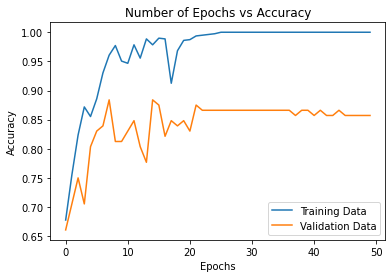

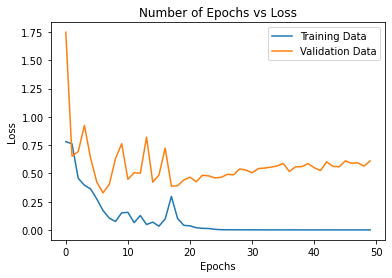

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.

plot_graph(max_epoch, train_epoch_acc_fcn, val_epoch_acc_fcn, train_epoch_loss_fcn, val_epoch_loss_fcn)


### Test [5 points]
As the final step of your analysis, you will test your model using some metrics. For the best model you obtained during training, evaluate your model on the test set. Then, report the confusion matrix. Finally, report accuracy, precision, recall, and $F_1$ score using your model. Report all these metrics using the macro form (macro precision, macro recall, etc.). You can implement these metrics in the cell below. 

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
#Test Data
accurate_avg_fcn, test_pred_label_fcn, test_batch_label_fcn = test_model(model_fcn, cross_entropy, optimizer, max_epoch)

The test accuracy is 0.8355555555555556


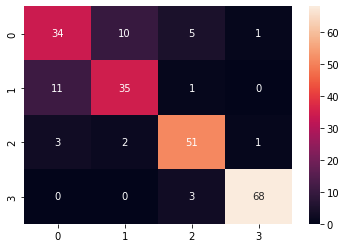

In [ ]:
confusion_matrix_fcn = torch.zeros(4,4, dtype = torch.int64)

for i in range(test_size):
    ground_truth = test_batch_label_fcn[i].int()
    predicted_label = test_pred_label_fcn[i].int()
    confusion_matrix_fcn[ground_truth,predicted_label] += 1

sns.heatmap(confusion_matrix_fcn.numpy(),annot=True,fmt="d")

In [ ]:
target_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
print("Accuracy score for Fully Connected Network: \n", accuracy_score(y_true = test_batch_label_fcn,  y_pred = test_pred_label_fcn))
print("Precision score for Fully Connected Network: \n", precision_score(y_true = test_batch_label_fcn,  y_pred = test_pred_label_fcn, average='macro'))
print("Recall score for Fully Connected Network: \n", recall_score(y_true = test_batch_label_fcn,  y_pred = test_pred_label_fcn, average='macro'))
print("F1 score for Fully Connected Network: \n", f1_score(y_true = test_batch_label_fcn,  y_pred = test_pred_label_fcn, average='macro'))

Accuracy score for Fully Connected Network: 
 0.8355555555555556
Precision score for Fully Connected Network: 
 0.8186106889564336
Recall score for Fully Connected Network: 
 0.8192910430105831
F1 score for Fully Connected Network: 
 0.8187230702428271


## Training and evaluation of CNN [22 points]
Similar to the FCN model, you will now train the CNN model that you defined before. Again you are free to try out different hyperparameters. This model also will classify weather images with the four classes provided by the dataset. As the optimizer, again, use the SGD implementation provided by PyTorch. You can implement the training loop in the following cell. 

Similar to the training procedure, you need to save the best model you obtain during training. Select an appropriate criterion (metric) to save the best model. If you wish, you can add a markdown cell to explain your reasoning.

### Training [12 points]

In [ ]:
#HINT: note that your training time should not take many days.

#TODO:
#The optimal hyperparameters are the given ones among what I tried before, except for the number of epochs.
max_epoch = 50
train_batch = 64
test_batch = 64
learning_rate = 5e-2
momentum = 0.5
weight_decay = 5e-04

# TODO: training loop + eval
model_cnn = ConvNet()
#Cross-Entropy Loss is used for classification problems and it is the criterion to detect the optimal hyperparameters
cross_entropy = nn.CrossEntropyLoss()
#Implement SGD and get the learnable parameters of the model
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

train_epoch_acc_cnn, train_epoch_loss_cnn, val_epoch_acc_cnn, val_epoch_loss_cnn = train_model(model_cnn, cross_entropy, optimizer, max_epoch)

Epoch:  1 / 50


100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


The training loss for the 1 th epoch is 0.9410919776329627
The training accuracy for the 1 th epoch is 0.5532994923857868
The validation loss for the 1 th epoch is 0.44614726305007935
The validation accuracy for the 1 th epoch is 0.8482142857142857
Epoch:  2 / 50


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


The training loss for the 2 th epoch is 0.8471851646900177
The training accuracy for the 2 th epoch is 0.733502538071066
The validation loss for the 2 th epoch is 0.7250977009534836
The validation accuracy for the 2 th epoch is 0.7321428571428571
Epoch:  3 / 50


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


The training loss for the 3 th epoch is 0.4453570017447838
The training accuracy for the 3 th epoch is 0.8197969543147208
The validation loss for the 3 th epoch is 0.3385719358921051
The validation accuracy for the 3 th epoch is 0.8839285714285714
Epoch:  4 / 50


100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


The training loss for the 4 th epoch is 0.4623551494800128
The training accuracy for the 4 th epoch is 0.8312182741116751
The validation loss for the 4 th epoch is 0.3695211559534073
The validation accuracy for the 4 th epoch is 0.9017857142857143
Epoch:  5 / 50


100%|██████████| 13/13 [00:33<00:00,  2.57s/it]


The training loss for the 5 th epoch is 0.3002113883311932
The training accuracy for the 5 th epoch is 0.8883248730964467
The validation loss for the 5 th epoch is 0.27231477200984955
The validation accuracy for the 5 th epoch is 0.9196428571428571
Epoch:  6 / 50


100%|██████████| 13/13 [00:31<00:00,  2.44s/it]


The training loss for the 6 th epoch is 0.22464543007887328
The training accuracy for the 6 th epoch is 0.9213197969543148
The validation loss for the 6 th epoch is 0.2473442405462265
The validation accuracy for the 6 th epoch is 0.9196428571428571
Epoch:  7 / 50


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


The training loss for the 7 th epoch is 0.3091740424816425
The training accuracy for the 7 th epoch is 0.881979695431472
The validation loss for the 7 th epoch is 0.5666787624359131
The validation accuracy for the 7 th epoch is 0.8214285714285714
Epoch:  8 / 50


100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


The training loss for the 8 th epoch is 0.20655663712666586
The training accuracy for the 8 th epoch is 0.9225888324873096
The validation loss for the 8 th epoch is 0.26696402952075005
The validation accuracy for the 8 th epoch is 0.9107142857142857
Epoch:  9 / 50


100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


The training loss for the 9 th epoch is 0.15048585545558196
The training accuracy for the 9 th epoch is 0.9581218274111675
The validation loss for the 9 th epoch is 0.45799706876277924
The validation accuracy for the 9 th epoch is 0.8660714285714286
Epoch:  10 / 50


100%|██████████| 13/13 [00:30<00:00,  2.33s/it]


The training loss for the 10 th epoch is 0.24682431954603928
The training accuracy for the 10 th epoch is 0.9060913705583756
The validation loss for the 10 th epoch is 0.2875553146004677
The validation accuracy for the 10 th epoch is 0.9107142857142857
Epoch:  11 / 50


100%|██████████| 13/13 [00:29<00:00,  2.26s/it]


The training loss for the 11 th epoch is 0.1600617250570884
The training accuracy for the 11 th epoch is 0.9416243654822335
The validation loss for the 11 th epoch is 0.2847493290901184
The validation accuracy for the 11 th epoch is 0.9107142857142857
Epoch:  12 / 50


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


The training loss for the 12 th epoch is 0.14013396833951658
The training accuracy for the 12 th epoch is 0.9517766497461929
The validation loss for the 12 th epoch is 0.31966690719127655
The validation accuracy for the 12 th epoch is 0.8928571428571429
Epoch:  13 / 50


100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


The training loss for the 13 th epoch is 0.10704081276288399
The training accuracy for the 13 th epoch is 0.9619289340101523
The validation loss for the 13 th epoch is 0.23747381567955017
The validation accuracy for the 13 th epoch is 0.9285714285714286
Epoch:  14 / 50


100%|██████████| 13/13 [00:29<00:00,  2.26s/it]


The training loss for the 14 th epoch is 0.09324366986178435
The training accuracy for the 14 th epoch is 0.9657360406091371
The validation loss for the 14 th epoch is 0.24642784148454666
The validation accuracy for the 14 th epoch is 0.9196428571428571
Epoch:  15 / 50


100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


The training loss for the 15 th epoch is 0.08299650939611289
The training accuracy for the 15 th epoch is 0.9657360406091371
The validation loss for the 15 th epoch is 0.2531144544482231
The validation accuracy for the 15 th epoch is 0.9107142857142857
Epoch:  16 / 50


100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


The training loss for the 16 th epoch is 0.08329558988603261
The training accuracy for the 16 th epoch is 0.9733502538071066
The validation loss for the 16 th epoch is 0.28599655628204346
The validation accuracy for the 16 th epoch is 0.8839285714285714
Epoch:  17 / 50


100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


The training loss for the 17 th epoch is 0.05571008781687571
The training accuracy for the 17 th epoch is 0.9847715736040609
The validation loss for the 17 th epoch is 0.35897619277238846
The validation accuracy for the 17 th epoch is 0.8928571428571429
Epoch:  18 / 50


100%|██████████| 13/13 [00:29<00:00,  2.26s/it]


The training loss for the 18 th epoch is 0.040564401934926324
The training accuracy for the 18 th epoch is 0.9885786802030457
The validation loss for the 18 th epoch is 0.31736891716718674
The validation accuracy for the 18 th epoch is 0.8928571428571429
Epoch:  19 / 50


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


The training loss for the 19 th epoch is 0.02932067899606549
The training accuracy for the 19 th epoch is 0.9847715736040609
The validation loss for the 19 th epoch is 0.28154246881604195
The validation accuracy for the 19 th epoch is 0.9464285714285714
Epoch:  20 / 50


100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


The training loss for the 20 th epoch is 0.016116430159085073
The training accuracy for the 20 th epoch is 0.9936548223350253
The validation loss for the 20 th epoch is 0.2100098952651024
The validation accuracy for the 20 th epoch is 0.9375
Epoch:  21 / 50


100%|██████████| 13/13 [00:28<00:00,  2.23s/it]


The training loss for the 21 th epoch is 0.06150535957959409
The training accuracy for the 21 th epoch is 0.983502538071066
The validation loss for the 21 th epoch is 0.1713857538998127
The validation accuracy for the 21 th epoch is 0.9375
Epoch:  22 / 50


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


The training loss for the 22 th epoch is 0.03304871193204935
The training accuracy for the 22 th epoch is 0.9885786802030457
The validation loss for the 22 th epoch is 0.11550641246140003
The validation accuracy for the 22 th epoch is 0.9642857142857143
Epoch:  23 / 50


100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


The training loss for the 23 th epoch is 0.043966062080401644
The training accuracy for the 23 th epoch is 0.9860406091370558
The validation loss for the 23 th epoch is 0.32058437168598175
The validation accuracy for the 23 th epoch is 0.9196428571428571
Epoch:  24 / 50


100%|██████████| 13/13 [00:29<00:00,  2.23s/it]


The training loss for the 24 th epoch is 0.1373883362572927
The training accuracy for the 24 th epoch is 0.9555837563451777
The validation loss for the 24 th epoch is 0.29133255779743195
The validation accuracy for the 24 th epoch is 0.9107142857142857
Epoch:  25 / 50


100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


The training loss for the 25 th epoch is 0.0523130467806298
The training accuracy for the 25 th epoch is 0.9873096446700508
The validation loss for the 25 th epoch is 0.6875376999378204
The validation accuracy for the 25 th epoch is 0.8214285714285714
Epoch:  26 / 50


100%|██████████| 13/13 [00:28<00:00,  2.23s/it]


The training loss for the 26 th epoch is 0.07104355161293195
The training accuracy for the 26 th epoch is 0.983502538071066
The validation loss for the 26 th epoch is 0.235677570104599
The validation accuracy for the 26 th epoch is 0.9285714285714286
Epoch:  27 / 50


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


The training loss for the 27 th epoch is 0.021508739081372578
The training accuracy for the 27 th epoch is 0.9936548223350253
The validation loss for the 27 th epoch is 0.3537941575050354
The validation accuracy for the 27 th epoch is 0.9017857142857143
Epoch:  28 / 50


100%|██████████| 13/13 [00:29<00:00,  2.26s/it]


The training loss for the 28 th epoch is 0.02961560867082041
The training accuracy for the 28 th epoch is 0.9885786802030457
The validation loss for the 28 th epoch is 0.1991834156215191
The validation accuracy for the 28 th epoch is 0.9464285714285714
Epoch:  29 / 50


100%|██████████| 13/13 [00:30<00:00,  2.31s/it]


The training loss for the 29 th epoch is 0.007227688606900091
The training accuracy for the 29 th epoch is 1.0
The validation loss for the 29 th epoch is 0.14310889318585396
The validation accuracy for the 29 th epoch is 0.9732142857142857
Epoch:  30 / 50


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


The training loss for the 30 th epoch is 0.002638692698942927
The training accuracy for the 30 th epoch is 1.0
The validation loss for the 30 th epoch is 0.18716979026794434
The validation accuracy for the 30 th epoch is 0.9464285714285714
Epoch:  31 / 50


100%|██████████| 13/13 [00:29<00:00,  2.23s/it]


The training loss for the 31 th epoch is 0.0033151697582350327
The training accuracy for the 31 th epoch is 1.0
The validation loss for the 31 th epoch is 0.17854646779596806
The validation accuracy for the 31 th epoch is 0.9732142857142857
Epoch:  32 / 50


100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


The training loss for the 32 th epoch is 0.01310623640445276
The training accuracy for the 32 th epoch is 0.9961928934010152
The validation loss for the 32 th epoch is 0.18828540947288275
The validation accuracy for the 32 th epoch is 0.9553571428571429
Epoch:  33 / 50


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


The training loss for the 33 th epoch is 0.0065057755888959104
The training accuracy for the 33 th epoch is 0.998730964467005
The validation loss for the 33 th epoch is 0.2101457342505455
The validation accuracy for the 33 th epoch is 0.9553571428571429
Epoch:  34 / 50


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


The training loss for the 34 th epoch is 0.07136965736460227
The training accuracy for the 34 th epoch is 0.9746192893401016
The validation loss for the 34 th epoch is 0.3300693929195404
The validation accuracy for the 34 th epoch is 0.9464285714285714
Epoch:  35 / 50


100%|██████████| 13/13 [00:30<00:00,  2.31s/it]


The training loss for the 35 th epoch is 0.012976315051603775
The training accuracy for the 35 th epoch is 0.9949238578680203
The validation loss for the 35 th epoch is 0.2227282002568245
The validation accuracy for the 35 th epoch is 0.9464285714285714
Epoch:  36 / 50


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


The training loss for the 36 th epoch is 0.008268589230003552
The training accuracy for the 36 th epoch is 0.998730964467005
The validation loss for the 36 th epoch is 0.24807188659906387
The validation accuracy for the 36 th epoch is 0.9285714285714286
Epoch:  37 / 50


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


The training loss for the 37 th epoch is 0.0267392832499284
The training accuracy for the 37 th epoch is 0.9936548223350253
The validation loss for the 37 th epoch is 0.15578112192451954
The validation accuracy for the 37 th epoch is 0.9553571428571429
Epoch:  38 / 50


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


The training loss for the 38 th epoch is 0.0041521933431235645
The training accuracy for the 38 th epoch is 0.998730964467005
The validation loss for the 38 th epoch is 0.20702979154884815
The validation accuracy for the 38 th epoch is 0.9464285714285714
Epoch:  39 / 50


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


The training loss for the 39 th epoch is 0.03017136041979449
The training accuracy for the 39 th epoch is 0.9911167512690355
The validation loss for the 39 th epoch is 0.24535474926233292
The validation accuracy for the 39 th epoch is 0.9196428571428571
Epoch:  40 / 50


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


The training loss for the 40 th epoch is 0.002785850130469323
The training accuracy for the 40 th epoch is 1.0
The validation loss for the 40 th epoch is 0.19718907959759235
The validation accuracy for the 40 th epoch is 0.9642857142857143
Epoch:  41 / 50


100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


The training loss for the 41 th epoch is 0.001084383315173909
The training accuracy for the 41 th epoch is 1.0
The validation loss for the 41 th epoch is 0.18852250277996063
The validation accuracy for the 41 th epoch is 0.9732142857142857
Epoch:  42 / 50


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


The training loss for the 42 th epoch is 0.0018175946226200233
The training accuracy for the 42 th epoch is 1.0
The validation loss for the 42 th epoch is 0.2580152116715908
The validation accuracy for the 42 th epoch is 0.9464285714285714
Epoch:  43 / 50


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


The training loss for the 43 th epoch is 0.0007606128391881401
The training accuracy for the 43 th epoch is 1.0
The validation loss for the 43 th epoch is 0.23459438979625702
The validation accuracy for the 43 th epoch is 0.9642857142857143
Epoch:  44 / 50


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


The training loss for the 44 th epoch is 0.0005027101433370262
The training accuracy for the 44 th epoch is 1.0
The validation loss for the 44 th epoch is 0.19672909379005432
The validation accuracy for the 44 th epoch is 0.9464285714285714
Epoch:  45 / 50


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


The training loss for the 45 th epoch is 0.022684600244526967
The training accuracy for the 45 th epoch is 0.9961928934010152
The validation loss for the 45 th epoch is 1.0254840850830078
The validation accuracy for the 45 th epoch is 0.7946428571428571
Epoch:  46 / 50


100%|██████████| 13/13 [00:28<00:00,  2.23s/it]


The training loss for the 46 th epoch is 0.16376853687688708
The training accuracy for the 46 th epoch is 0.9644670050761421
The validation loss for the 46 th epoch is 0.4482535719871521
The validation accuracy for the 46 th epoch is 0.9107142857142857
Epoch:  47 / 50


100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


The training loss for the 47 th epoch is 0.09901479123016962
The training accuracy for the 47 th epoch is 0.9708121827411168
The validation loss for the 47 th epoch is 0.1870253011584282
The validation accuracy for the 47 th epoch is 0.9464285714285714
Epoch:  48 / 50


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


The training loss for the 48 th epoch is 0.008275346239455618
The training accuracy for the 48 th epoch is 0.998730964467005
The validation loss for the 48 th epoch is 0.2115936502814293
The validation accuracy for the 48 th epoch is 0.9464285714285714
Epoch:  49 / 50


100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


The training loss for the 49 th epoch is 0.0030424468792401827
The training accuracy for the 49 th epoch is 1.0
The validation loss for the 49 th epoch is 0.14383249916136265
The validation accuracy for the 49 th epoch is 0.9732142857142857
Epoch:  50 / 50


100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


The training loss for the 50 th epoch is 0.0015466034081048118
The training accuracy for the 50 th epoch is 1.0
The validation loss for the 50 th epoch is 0.14194484427571297
The validation accuracy for the 50 th epoch is 0.9732142857142857


### Learning Process Analysis [3 points]
Repeating the same procedure you applied for the FCN model; you will provide two plots about how your training proceeds over epochs. Again, provide two plots: one summarizes the loss values, and the other summarizes the accuracy values. Note that each plot needs to include two curves, one for the validation set and the other for the training set.

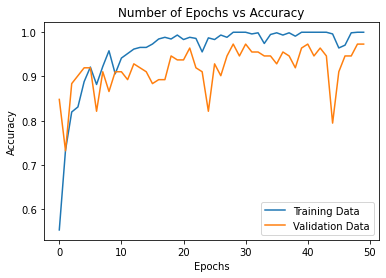

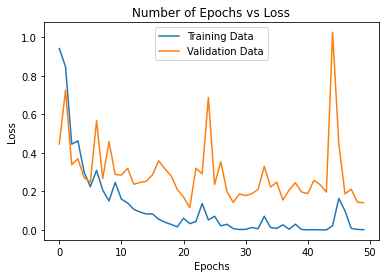

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.

plot_graph(max_epoch, train_epoch_acc_cnn, val_epoch_acc_cnn, train_epoch_loss_cnn, val_epoch_loss_cnn)

### Test [4 points]
Concluding your analysis, report the confusion matrix for the best model you obtained during your CNN model training. Then using this confusion matrix, report accuracy, recall, precision, and $F_1$ score for your best model. Use macro averaging in all of your metrics.

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
#Test Data
accurate_avg_cnn, test_pred_label_cnn, test_batch_label_cnn = test_model(model_cnn, cross_entropy, optimizer, max_epoch)

The test accuracy is 0.9244444444444444


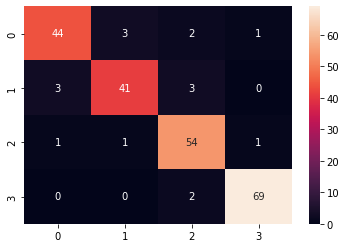

In [ ]:
confusion_matrix_cnn = torch.zeros(4,4, dtype = torch.int64)

for i in range(test_size):
    ground_truth = test_batch_label_cnn[i].int()
    predicted_label = test_pred_label_cnn[i].int()
    confusion_matrix_cnn[ground_truth,predicted_label] += 1

sns.heatmap(confusion_matrix_cnn.numpy(),annot=True,fmt="d")

In [ ]:
target_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
print("Accuracy score for Fully Connected Network: \n", accuracy_score(y_true = test_batch_label_cnn,  y_pred = test_pred_label_cnn))
print("Precision score for Fully Connected Network: \n", precision_score(y_true = test_batch_label_cnn,  y_pred = test_pred_label_cnn, average='macro'))
print("Recall score for Fully Connected Network: \n", recall_score(y_true = test_batch_label_cnn,  y_pred = test_pred_label_cnn, average='macro'))
print("F1 score for Fully Connected Network: \n", f1_score(y_true = test_batch_label_cnn,  y_pred = test_pred_label_cnn, average='macro'))

Accuracy score for Fully Connected Network: 
 0.9244444444444444
Precision score for Fully Connected Network: 
 0.9212136663331537
Recall score for Fully Connected Network: 
 0.9178849581250098
F1 score for Fully Connected Network: 
 0.9190871886757963


### Discussion [3 points]
Now, try to compare the two models that you trained. How different are these two models regarding the number of parameters used?

Explain your findings by connecting them with your experimental results. You can include your comments on a separate Markdown cell or below the question statement.

**Answer:** According to the results, CNN is a better model for this image classification 
problem. The difference between these models are, FCN processes flattened images while CNN works with multi-dimensional inputs and filter them using its parameter kernel_size, and it flattens the image later. FCN might lose some useful information at the beginning, and this is why CNN works better. 





## Transfer Learning [22 points]

As the last part of this assignment, you will practice transfer learning. In this methodology, we aim to use models trained on large-scale datasets for our task. As we do not have access to large datasets and computational resources all the time, we sometimes try to use already trained models (on other datasets) as a good starting point for our model, and then fine-tune the weights considering our task.  

Torchvision library provides numerous models pretrained for specific tasks. [Here](https://pytorch.org/vision/stable/models.html), you can find a list of pretrained models. For this part, you will include [ResNet](https://arxiv.org/abs/1512.03385)-18 model, pretrained with ImageNet dataset. ImageNet is a large dataset where training from scratch would take a long time. You will fine-tune this pretrained module for your task. 
<br>
**Hint:** You can add a Linear layer to adapt the model to the number of classes needed for your task. You can access the number of inputs to the ResNet-18 model as $\texttt{model.fc.in_features}$ and then modify the fully connected layer of the model $\texttt{model.fc}$.
<br>

Using the ResNet-18 backbone, implement this model's training loop (by adapting it to your task). You can implement the training procedure in the cell provided below. Again save your model based on a criterion indicating the best model. Explain the reasoning for your criteria. Use the SGD optimizer provided by PyTorch to optimize your model.

Just like the previous parts, you can also tune your hyperparameters to optimize your model's performance. 

###Training [12 points]

In [ ]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters

#The optimal hyperparameters according to my trials are the given ones.
max_epoch = 10
train_batch = 64
test_batch = 64
learning_rate = 9e-2
weight_decay = 5e-04

# TODO: Implement training loop + eval using ResNet-18 model
model_tl = models.resnet18(pretrained=True)

for param in model_tl.parameters():
  param.requires_grad = False

#Replace your last fully-connected layer
num_inputs = model_tl.fc.in_features
model_tl.fc = nn.Linear(num_inputs,4)

#Calculating loss
cross_entropy = nn.CrossEntropyLoss()

#Optimize only the classifier
optimizer = torch.optim.SGD(model_tl.fc.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)

train_epoch_acc_tl, train_epoch_loss_tl, val_epoch_acc_tl, val_epoch_loss_tl = train_model(model_tl, cross_entropy, optimizer, max_epoch)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch:  1 / 10


100%|██████████| 13/13 [01:01<00:00,  4.73s/it]


The training loss for the 1 th epoch is 5.948519174869244
The training accuracy for the 1 th epoch is 0.39213197969543145
The validation loss for the 1 th epoch is 1.2068668007850647
The validation accuracy for the 1 th epoch is 0.8125
Epoch:  2 / 10


100%|██████████| 13/13 [00:58<00:00,  4.50s/it]


The training loss for the 2 th epoch is 0.2970112143800809
The training accuracy for the 2 th epoch is 0.9238578680203046
The validation loss for the 2 th epoch is 0.33375825732946396
The validation accuracy for the 2 th epoch is 0.9017857142857143
Epoch:  3 / 10


100%|██████████| 13/13 [01:01<00:00,  4.72s/it]


The training loss for the 3 th epoch is 0.227667377402003
The training accuracy for the 3 th epoch is 0.9403553299492385
The validation loss for the 3 th epoch is 0.12882190197706223
The validation accuracy for the 3 th epoch is 0.9553571428571429
Epoch:  4 / 10


100%|██████████| 13/13 [00:57<00:00,  4.45s/it]


The training loss for the 4 th epoch is 0.1206232773569914
The training accuracy for the 4 th epoch is 0.9581218274111675
The validation loss for the 4 th epoch is 0.23524107038974762
The validation accuracy for the 4 th epoch is 0.9196428571428571
Epoch:  5 / 10


100%|██████████| 13/13 [01:00<00:00,  4.64s/it]


The training loss for the 5 th epoch is 0.13606165492763886
The training accuracy for the 5 th epoch is 0.9593908629441624
The validation loss for the 5 th epoch is 0.22491461783647537
The validation accuracy for the 5 th epoch is 0.9196428571428571
Epoch:  6 / 10


100%|██████████| 13/13 [01:07<00:00,  5.22s/it]


The training loss for the 6 th epoch is 0.07952618498641711
The training accuracy for the 6 th epoch is 0.9657360406091371
The validation loss for the 6 th epoch is 0.17844842374324799
The validation accuracy for the 6 th epoch is 0.9285714285714286
Epoch:  7 / 10


100%|██████████| 13/13 [00:59<00:00,  4.61s/it]


The training loss for the 7 th epoch is 0.10252586845308542
The training accuracy for the 7 th epoch is 0.9631979695431472
The validation loss for the 7 th epoch is 0.2776358798146248
The validation accuracy for the 7 th epoch is 0.9196428571428571
Epoch:  8 / 10


100%|██████████| 13/13 [00:59<00:00,  4.55s/it]


The training loss for the 8 th epoch is 0.18887150144347778
The training accuracy for the 8 th epoch is 0.9378172588832487
The validation loss for the 8 th epoch is 0.1354985050857067
The validation accuracy for the 8 th epoch is 0.9553571428571429
Epoch:  9 / 10


100%|██████████| 13/13 [01:05<00:00,  5.03s/it]


The training loss for the 9 th epoch is 0.0453911405773117
The training accuracy for the 9 th epoch is 0.983502538071066
The validation loss for the 9 th epoch is 0.1291534509509802
The validation accuracy for the 9 th epoch is 0.9553571428571429
Epoch:  10 / 10


100%|██████████| 13/13 [01:12<00:00,  5.55s/it]


The training loss for the 10 th epoch is 0.06407890712412503
The training accuracy for the 10 th epoch is 0.9758883248730964
The validation loss for the 10 th epoch is 0.17064178735017776
The validation accuracy for the 10 th epoch is 0.9553571428571429


###Learning Process Analysis [3 points]
After training your model, provide two plots summarizing the learning procedure. Like previous parts, you will provide plots for loss value and accuracy progression over epochs. Remember that for each plot, you need to include two curves (one for the training set and one for the validation set).

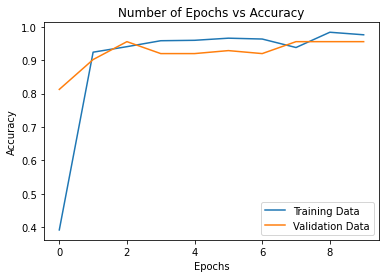

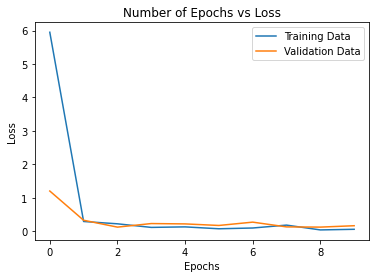

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
plot_graph(max_epoch, train_epoch_acc_tl, val_epoch_acc_tl, train_epoch_loss_tl, val_epoch_loss_tl)

### Test [4 points]
Following your analysis, report the confusion matrix for the best model you obtained (with the criteria you defined). Then, report the accuracy, precision, recall and $F_1$ score for the best model. In all of the metrics, use macro averaging.

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics

accurate_avg_tl, test_pred_label_tl, test_batch_label_tl = test_model(model_tl, cross_entropy, optimizer, max_epoch)

The test accuracy is 0.9377777777777778


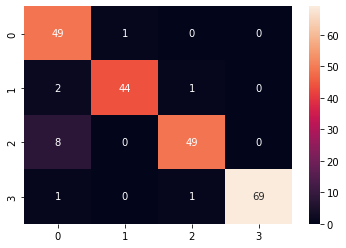

In [ ]:
confusion_matrix_tl = torch.zeros(4,4, dtype = torch.int64)

for i in range(test_size):
    ground_truth = test_batch_label_tl[i].int()
    predicted_label = test_pred_label_tl[i].int()
    confusion_matrix_tl[ground_truth,predicted_label] += 1

sns.heatmap(confusion_matrix_tl.numpy(),annot=True,fmt="d")

In [ ]:
target_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
print("Accuracy score for Fully Connected Network: \n", accuracy_score(y_true = test_batch_label_tl,  y_pred = test_pred_label_tl))
print("Precision score for Fully Connected Network: \n", precision_score(y_true = test_batch_label_tl,  y_pred = test_pred_label_tl, average='macro'))
print("Recall score for Fully Connected Network: \n", recall_score(y_true = test_batch_label_tl,  y_pred = test_pred_label_tl, average='macro'))
print("F1 score for Fully Connected Network: \n", f1_score(y_true = test_batch_label_tl,  y_pred = test_pred_label_tl, average='macro'))

Accuracy score for Fully Connected Network: 
 0.9377777777777778
Precision score for Fully Connected Network: 
 0.9388071895424837
Recall score for Fully Connected Network: 
 0.936912580372117
F1 score for Fully Connected Network: 
 0.9351381307903047


### Discussion [3 points]
Now discuss the effectiveness of Transfer Learning. How does it improve performance?  



**Answer:** It has an additive effect on the test accuracy. The best model was CNN with 0.924 test accuracy before transfer learning, now it is 0.938. Even it is a slight increase, it still has a positive impact on classification. The reason is the model was already trained with other models, hence recognizing patterns were easier for the model itself. 

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1